Analyzing sentiment of tweets

- The goal of this notebook is to classify a tweet as having positive sentiment (1) or negative sentiment (-1)
- Github Link containing all datasets, notebooks, slides, and video: https://github.com/Niddish/MachineLearningForEngineersFinalProject

In [52]:
#importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier


#load dataset
file_path = 'sentiment_data/stock_data_binary_class.csv'  
data = pd.read_csv(file_path)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB
None

Target Distribution:
Sentiment
 1    3685
-1    2106
Name: count, dtype: int64


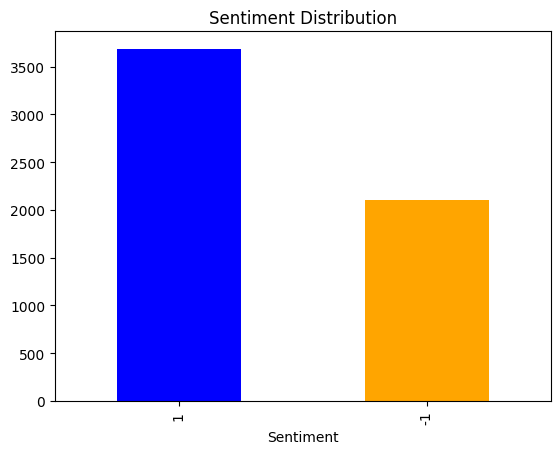


Sample Tweets:
0    Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1    user: AAP MOVIE. 55% return for the FEA/GEED i...
2    user I'd be afraid to short AMZN - they are lo...
3                                    MNTA Over 12.00  
4                                     OI  Over 21.37  
Name: Text, dtype: object


In [53]:
#data exploration

print("Dataset Info:")
print(data.info())

print("\nTarget Distribution:")
print(data['Sentiment'].value_counts())

#plot distribution
data['Sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution', color=['blue', 'orange'])
plt.show()

#preview tweets
print("\nSample Tweets:")
print(data['Text'].head())

From our data exploration, we can see that there are 5791 tweets in the dataset, with 3685 being positve and 2106 being negative. A simple chart to show the values as well as some example tweets are also printed.

For data preprocessing, we want to clean the data to not only prepare it for tokenization, but to deal with any ethical issues that might arise with a tweet being data-scraped. We use the RE module to perform this cleaning.

In [54]:
#data preprocessing

def basic_cleaning(text):
    text = text.lower()  #convert to lowercase
    text = re.sub(r'@\w+', '', text)  #remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  #remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  #remove spaces
    return text

data['Cleaned_Text'] = data['Text'].apply(basic_cleaning)


Our feature extraction involves converting the text data into numerical features so that ML models can process them. We use the TfidVectorizer function from sklearn, which works by assigning each word a term frequency (how often it shows up in a tweet), and then adjusting this value based on how often it shows up across all tweets. We maximize the features to 5000 and remove any common english stopwords. From this, we geta  matrix where each row represents a tweet, and each column represents the importance of a term.

In [55]:
#feature extraction

from sklearn.feature_extraction.text import TfidfVectorizer

#cleaned data from preprocesssing
cleaned_data = data['Cleaned_Text']

#Use TF-IDF vector
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

#fit and transform data
tfidf_features = tfidf_vectorizer.fit_transform(cleaned_data)
print("TF-IDF Features Shape:", tfidf_features.shape)


TF-IDF Features Shape: (5791, 5000)


Our first ML technique for classifying is Naive Bayes. We chose this because it is highly efficient and works particularly well with high-dimensional, sparse data like the TF-IDF matrix generated from our tweets. Naive Bayes works by learning the probabilities of each word appearing in a specific sentiment class (positive or negative) and uses Bayes' Theorem to make predictions. We implemented this using the MultinomialNB function from sklearn, which is designed for multinomially distributed data, making it a great fit for our TF-IDF features. After training the model on the dataset, it predicts sentiment by selecting the class with the highest posterior probability for a given tweet. We calculated various evalution metrics for the Naive Bayes classifier, such as accuracy, precision, recall, and F1-score. After, we perform 5-fold cross validation, implemented using the StratifiedKFold function from sklearn, which ensures that distribution of positive and negative sentiments is preserved across all folds. We then compare this with the initial Naive Bayes results, and since they are similar, we know our model is robust.

In [56]:
#ML technique 1 - naive bayes

#split the data (no k-folds)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, data['Sentiment'], test_size=0.2, random_state=42)

#train classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

#make predictions and evaluate
y_pred_nb = nb_classifier.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

#perform k-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nb_classifier = MultinomialNB()
nb_cv_scores = cross_val_score(nb_classifier, tfidf_features, data['Sentiment'], cv=cv, scoring='accuracy')

print("Naive Bayes Cross-Validation Accuracy Scores:", nb_cv_scores)
print("Mean Accuracy:", nb_cv_scores.mean())

 

Naive Bayes Accuracy: 0.7558239861949957
Classification Report:
               precision    recall  f1-score   support

          -1       0.82      0.44      0.57       427
           1       0.74      0.94      0.83       732

    accuracy                           0.76      1159
   macro avg       0.78      0.69      0.70      1159
weighted avg       0.77      0.76      0.73      1159

Naive Bayes Cross-Validation Accuracy Scores: [0.76531493 0.74525043 0.7582038  0.74525043 0.74006908]
Mean Accuracy: 0.7508177349004039


Our second machine learning technique is k-Nearest Neighbors (k-NN). This algorithm classifies a tweet by looking at its "k" closest neighbors in the feature space and assigning the majority class among these neighbors. We chose this method because it offers a simple approach to classification, and it allows us to interpret how the proximity of tweets affects classification outcomes. We initialized the k-NN classifier using the KNeighborsClassifier function from sklearn with n_neighbors=5, meaning it considers the 5 nearest neighbors when making predictions. After training the model on the training set, we evaluated its performance on the test set using accuracy, precision, recall, and F1-score. Then, to find an optimal k-value, we implemented cross-validation for k values of 1-20 and graphing it to see which k-value maximizes accuracy without overfitting. From the graph, we pick k equal to 3, and then train the final model on that value.

k-NN Accuracy: 0.6557377049180327
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.08      0.15       427
           1       0.65      0.99      0.78       732

    accuracy                           0.66      1159
   macro avg       0.74      0.54      0.47      1159
weighted avg       0.72      0.66      0.55      1159



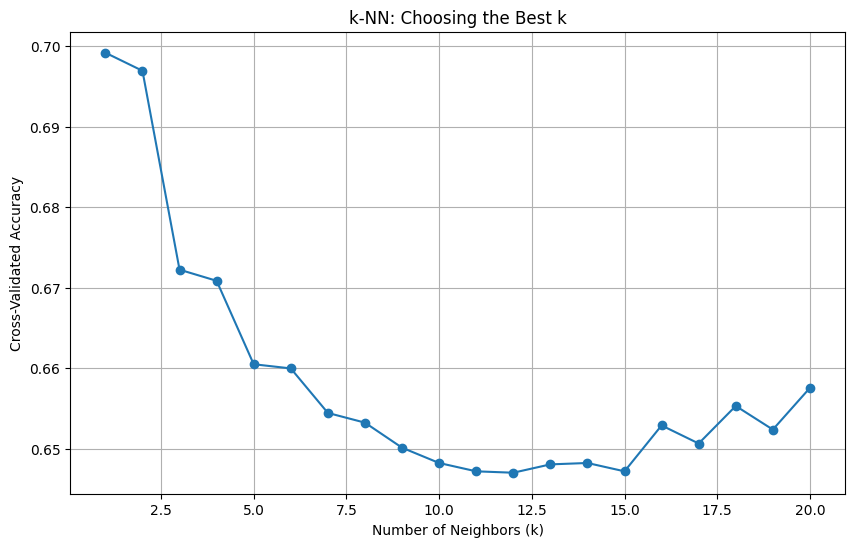

Final k-NN Accuracy (k=3): 0.6712683347713546
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.14      0.23       427
           1       0.66      0.98      0.79       732

    accuracy                           0.67      1159
   macro avg       0.74      0.56      0.51      1159
weighted avg       0.72      0.67      0.59      1159



In [57]:
#ML technique 2 - k-nearest neighbors

#initialize and train
knn_classifier = KNeighborsClassifier(n_neighbors=5)  #first run-through at k = 5
knn_classifier.fit(X_train, y_train)

#make predictions and evaluate
y_pred_knn = knn_classifier.predict(X_test)
print("k-NN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

#k-values to test for
k_values = range(1, 21)
k_accuracies = []

#perform-cross validation and plot
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_classifier, tfidf_features, data['Sentiment'], cv=cv, scoring='accuracy')
    k_accuracies.append(cv_scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_accuracies, marker='o')
plt.title("k-NN: Choosing the Best k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.grid()
plt.show()

#train knn based on this best k from graph
final_knn_classifier = KNeighborsClassifier(n_neighbors=3)
final_knn_classifier.fit(X_train, y_train)

# Final predictions and evaluation
y_pred_final_knn = final_knn_classifier.predict(X_test)
print(f"Final k-NN Accuracy (k={3}):", accuracy_score(y_test, y_pred_final_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_final_knn))


For our comparison, we get our metrics calculated earlier and display them in a bar graph for easier viewing. We can see that the Naive Bayes classifier performed better in all categories, which is what we expected, as it handles high-dimensional, sparse data (like TF-IDF) efficiently and is computationally well-suited for datasets with a large number of features and samples. While this is still a relatively small dataset, the computation for the optimal k-value took about 15-20 seconds, whereas everything else ran almost instantly, showing the efficency of Naive Bayes over KNN in this case.

Comparison Table:
             Accuracy  Precision    Recall  F1-Score
Naive Bayes  0.755824   0.768642  0.755824  0.733341
k-NN         0.671268   0.722836  0.671268  0.585426


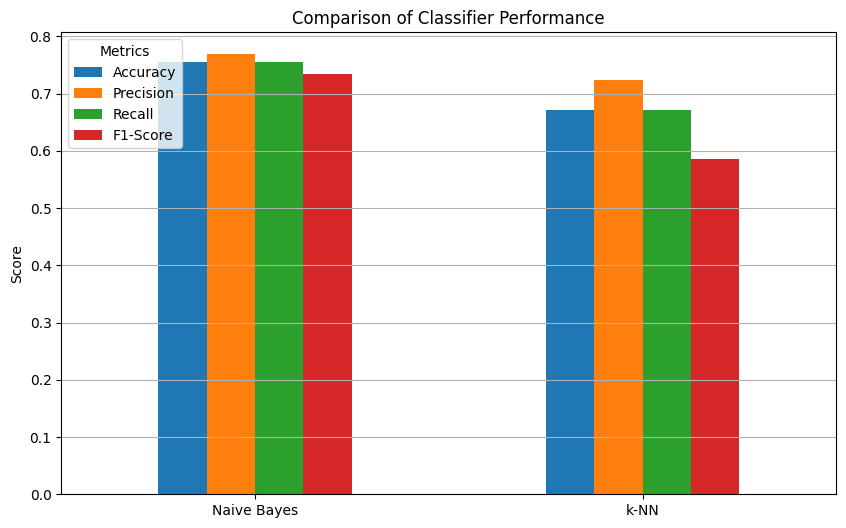

In [58]:
#comparison
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

#function to extract metrics
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

#naive bayes metrics
nb_metrics = get_metrics(y_test, y_pred_nb)

#knn metrics
knn_metrics = get_metrics(y_test, y_pred_final_knn)

#dataframe, table, and plot
comparison_df = pd.DataFrame([nb_metrics, knn_metrics], index=['Naive Bayes', 'k-NN'])
print("Comparison Table:")
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Classifier Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metrics', loc='upper left')
plt.grid(axis='y')
plt.show()



Lastly, as a sort of "practical" test (since the ideal scenario would be to data-scrape tweets in real-time and predict sentiment), we retrain the Naive Bayes classifier on all the data, and give it a postive and negative tweet that I have made up to see if classifies them correctly. We see that it does, and is a nice way to show our model works.

In [59]:
#train naive bayes on full dataset
tfidf_features = tfidf_vectorizer.transform(data['Cleaned_Text'])
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_features, data['Sentiment'])

#example tweets
tweets = [
    "Professor Bajwa says the Rutgers stock will skyrocket!",
    "Professor Bajwa says that we should short the Rutgers stock."
]

#classify tweets function based on naive bayes
def classify_tweet(tweet, classifier, vectorizer):
    cleaned_tweet = basic_cleaning(tweet)  # Clean the tweet
    transformed_tweet = vectorizer.transform([cleaned_tweet])  # Transform using TF-IDF
    predicted_sentiment = classifier.predict(transformed_tweet)  # Predict sentiment
    return "Positive" if predicted_sentiment[0] == 1 else "Negative"

#perform classification and print
for tweet in tweets:
    sentiment = classify_tweet(tweet, nb_classifier, tfidf_vectorizer)
    print(f"The tweet: \"{tweet}\" is classified as {sentiment}.")



The tweet: "Professor Bajwa says the Rutgers stock will skyrocket!" is classified as Positive.
The tweet: "Professor Bajwa says that we should short the Rutgers stock." is classified as Negative.


Ethical issues in this method arise mainly from the idea of data scraping, as people don't like the idea that their data is being used, even if they put it on the public domain. To deal with this, we remove "@" from the tweets in order to keep these tweets as non-personalized as possible. Other than that, and seeing as this is not a commercial system, but rather, something that we are using personally, there aren't really any ethical issues present, since all this information is avaiable to the public.

Bibliography

- https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset

- https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction

- https://www.geeksforgeeks.org/k-nearest-neighbours/

- https://www.geeksforgeeks.org/naive-bayes-classifiers/
